## STA 141B 
### Homework 3

### Your Name: Jasper Cheng

Submit only this ipynb to canvas.  Work in between the exercise cells and be clear about your answers.  For example, you should add cells below the cell starting with 1.1 for the answer to 1.1.  You can break your answers into as many cells as you like.  Please do not clear your output so that we can see your answers without running all of the cells.

Throughout this homework we will be using the the covidcast api, and you can find [the documentation here](https://cmu-delphi.github.io/delphi-epidata/).  We will be using the http api and you should not use the `covidcast` python package.  Even though it is available, I want to test you on using the requests package and making http requests directly.

In [2]:
import requests
import pandas as pd
import numpy as np
import sqlalchemy as sqla
import requests_cache
import plotnine as p9
requests_cache.install_cache('covidcast_cache')

ModuleNotFoundError: No module named 'requests_cache'

Read [the documentation about the Epidata API at this README](https://cmu-delphi.github.io/delphi-epidata/api/covidcast.html) and we will be using the covidcast "endpoint".  Pay special attention to the section "Constructing API Queries".  You will be making requests with the request package.  Consider the following get request...
```
https://api.covidcast.cmu.edu/epidata/api.php?endpoint=covidcast&data_source=fb-survey&signal=smoothed_cli&time_type=day&geo_type=county&time_values=20200406-20200410&geo_value=06001
```
If you put this in your browser you see...
```
{ "epidata": [{"geo_value":"06001","signal":"smoothed_cli","time_value":20200406,"direction":null,"issue":20200903,"lag":150,"value":0.0,"stderr":0.3691187,"sample_size":133.079},{"geo_value":"06001","signal":"smoothed_cli","time_value":20200407,"direction":null,"issue":20200903,"lag":149,"value":0.7510297,"stderr":0.3720838,"sample_size":422.8531},{"geo_value":"06001","signal":"smoothed_cli","time_value":20200408,"direction":null,"issue":20200903,"lag":148,"value":0.6378432,"stderr":0.2732424,"sample_size":685.658},{"geo_value":"06001","signal":"smoothed_cli","time_value":20200409,"direction":null,"issue":20200903,"lag":147,"value":0.6162563,"stderr":0.2433975,"sample_size":871.1857},{"geo_value":"06001","signal":"smoothed_cli","time_value":20200410,"direction":null,"issue":20200903,"lag":146,"value":0.7180705,"stderr":0.2483399,"sample_size":979.2376}], "result": 1, "message": "success" }
```
which is the json returned from this query.  The parameters for the query are 
```
endpoint=covidcast
data_source=fb-survey
signal=smoothed_cli
time_type=day
geo_type=county
time_values=20200406-20200410
geo_value=06001
```
which asks for the smoothed cli signal from the fb survey data for county 06001 from 2020-04-06 to 2020-04-10.  Notice that if you want to select all geo_values then you can set geo_value=*.

**Exercise 1.** Request the value for the smoothed_cli signal from the fb-survey datasource on 2020-10-01 for ALL STATES.  Notice that the above is for counties and so you need to change this to states.  Do the same for smoothed_hh_cmnty_cli signal from the fb-survey data, and the confirmed_7dav_incidence_prop signal from the jhu-csse data source.  Create dataframes from these and join these 3 variables based on the state into a single dataframe.  Drop rows with missingness (there should be only about 5 of them dropped this way, corresponding to the US territories).  Finally, compute and output the spearman correlation between all variables in this dataframe (there should be 51 rows in the new dataset). 

In [4]:
import requests
import pandas as pd
import json

r=requests.get('https://api.covidcast.cmu.edu/epidata/api.php?endpoint=covidcast&data_source=fb-survey&signal=smoothed_cli&time_type=day&geo_type=state&time_values=20201001&geo_value=*')
fbsm=pd.DataFrame.from_dict(list(json.loads(r.text).values())[0])[['geo_value','value']]
fbsm.head()

,geo_value,value
0,ak,1.585416
1,al,0.983292
2,ar,1.057655
3,az,0.597376
4,ca,0.450001


In [5]:
r=requests.get('https://api.covidcast.cmu.edu/epidata/api.php?endpoint=covidcast&data_source=fb-survey&signal=smoothed_hh_cmnty_cli&time_type=day&geo_type=state&time_values=20201001&geo_value=*')
fbhh=pd.DataFrame.from_dict(list(json.loads(r.text).values())[0])[['geo_value','value']]
fbhh.head()

,geo_value,value
0,ak,24.618585
1,al,25.393981
2,ar,29.244671
3,az,16.585878
4,ca,13.689740


In [6]:

r=requests.get('https://api.covidcast.cmu.edu/epidata/api.php?endpoint=covidcast&data_source=jhu-csse&signal=deaths_7dav_incidence_prop&time_type=day&geo_type=state&time_values=20201001&geo_value=*')
jhco=pd.DataFrame.from_dict(list(json.loads(r.text).values())[0])[['geo_value','value']]
jhco.head()

,geo_value,value
0,ak,0.217279
1,al,0.122369
2,ar,0.653266
3,as,0.000000
4,az,0.225707


In [7]:
from scipy.stats import spearmanr
data1=fbsm.merge(fbhh,left_on='geo_value',right_on='geo_value',suffixes=('_sm','_hh')).merge(jhco,left_on='geo_value',right_on='geo_value',suffixes=('','_jh'))
data1=data1.set_index('geo_value')
data1.head()

,value_sm,value_hh,value
geo_value,,,
ak,1.585416,24.618585,0.217279
al,0.983292,25.393981,0.122369
ar,1.057655,29.244671,0.653266
az,0.597376,16.585878,0.225707
ca,0.450001,13.689740,0.212592


In [317]:
print("The spearman correlation between the two facebook indicators is", spearmanr(data1["value_sm"],data1["value_hh"])[0])
print("The spearman correlation between the first facebook indicators and death incidence is",spearmanr(data1["value_sm"],data1["value"])[0])
print("The spearman correlation between the second facebook indicator and death incidence is",spearmanr(data1["value"],data1["value_hh"])[0])

The spearman correlation between the two facebook indicators is 0.8592760180995475
The spearman correlation between the first facebook indicators and death incidence is 0.49149321266968327
The spearman correlation between the second facebook indicator and death incidence is 0.5666063348416289


**Exercise 2.** Create and engine using sqlalchemy for a sqlite database (you can just use for example `covid.sqlite` as your location in your current directory).  You will sequentially pull these three variables above for each state at different dates  and write the resulting dataframes to a single table in the sqlite database.  Your date range should be from '2020-08-02' to '2021-04-04' at a frequency of every 7 days.  For each date, query the API for the three variables and construct the dataframe of each state at that date.  Then append this dataframe to a table (call the table "state") in the sqlite database that you created, using DataFrame.to_sql command.  Finally, make a sql query to this table that counts the number of rows in the state table, there should be 51 x the number of dates in your date range.

In [11]:
import sqlalchemy as sqla
engine=sqla.create_engine('sqlite:///covid.sqlite')

In [22]:
data2['time_value']=pd.to_datetime(data2['time_value'],format='%Y%m%d')
data2.sort_values('time_value').sort_values('geo_value')
weeks=pd.date_range("2020-08-02","2021-04-04",freq="W")
weeks=weeks.strftime('%Y%m%d')

In [87]:
combo=[['fb-survey','smoothed_cli'],['fb-survey','smoothed_hh_cmnty_cli'],['jhu-csse','deaths_7dav_incidence_prop']]
dataval1 = dataval2 = dataval3 = pd.DataFrame(columns=['geo_value','value','time_value'])
for day in weeks:
    val1 = requests.post('https://api.covidcast.cmu.edu/epidata/api.php?endpoint=covidcast&data_source={}&signal={}&time_type=day&geo_type=state&time_values={}&geo_value=*'.format(combo[0][0],combo[0][1],day))
    val2 = requests.post('https://api.covidcast.cmu.edu/epidata/api.php?endpoint=covidcast&data_source={}&signal={}&time_type=day&geo_type=state&time_values={}&geo_value=*'.format(combo[1][0],combo[1][1],day))
    val3 = requests.post('https://api.covidcast.cmu.edu/epidata/api.php?endpoint=covidcast&data_source={}&signal={}&time_type=day&geo_type=state&time_values={}&geo_value=*'.format(combo[2][0],combo[2][1],day))
    dataval1 = pd.concat([dataval1,pd.DataFrame.from_dict(list(json.loads(val1.text).values())[0])[['geo_value','value','time_value']]])
    dataval2 = pd.concat([dataval2,pd.DataFrame.from_dict(list(json.loads(val2.text).values())[0])[['geo_value','value','time_value']]])
    dataval3 = pd.concat([dataval3,pd.DataFrame.from_dict(list(json.loads(val3.text).values())[0])[['geo_value','value','time_value']]])

In [111]:
data2 = dataval1.merge(dataval2,how='left',left_on=['geo_value','time_value'],right_on=['geo_value','time_value'],suffixes=('_1','_2')).merge(dataval3,how='left',left_on=['geo_value','time_value'],right_on=['geo_value','time_value'],suffixes=())
data2 = data2.rename(columns={'geo_value':'State','time_value':'Date','value':'value_3'})
data2 = data2[['Date','State','value_1','value_2','value_3']]
data2.to_sql('state',engine, if_exists='replace')
pd.read_sql('select count(*) from state',engine)

,count(*)
0,1838


**Exercise 3.** Using `read_sql_query`, select all variables where the state is california from the state table, and read it into a pandas dataframe.  Filtering out CA should be done in SQL and then the pd.DataFrame should be constructed, the filter should not happen after you read in the full data.  In the end you should have one row for each date.  

For the two FB indicator variables, produce a plot comparing that to the death indicences.  Plot the FB indicator variables as a time series in a secondary y axis and the death indicence as the primary y axis.  You can just use pd.DataFrame.plot().  You should have the actual date on the X axis and not just an index number.  Remark on which indicator looks more variable and why they are good "leading indicators".  A leading indicator is a variable that rises and falls before the indicator of interest such as covid deaths.

In [118]:
data3 = pd.DataFrame((pd.read_sql("select * from state where State='ca' ",engine)))
data3

,index,Date,State,value_1,value_2,value_3
0,4,20200802,ca,0.632992,20.722805,0.347090
1,56,20200809,ca,0.585508,19.452885,0.340943
2,108,20200816,ca,0.544658,18.001714,0.330820
3,159,20200823,ca,0.493013,16.526177,0.326843
4,210,20200830,ca,0.387622,15.335234,0.287434
5,261,20200906,ca,0.452867,15.135193,0.294665
6,312,20200913,ca,0.387752,14.244466,0.237539
7,363,20200920,ca,0.444808,13.944817,0.228139
8,414,20200927,ca,0.422248,13.323191,0.213316
9,465,20201004,ca,0.414949,14.062189,0.197769


<AxesSubplot:xlabel='Date', ylabel='FB Indicator'>

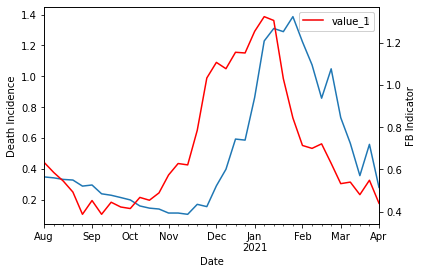

In [221]:
months=pd.date_range("2020-08-02","2021-04-04",freq="M")
data3['Date']=pd.to_datetime(data3['Date'],format='%Y%m%d')
plot3 = data3.plot('Date','value_3',ylabel='Death Incidence')
plot3b = plot3.twinx()
data3.plot("Date",'value_1',ax=plot3b, color="red",ylabel="COVID-Like Symptoms")

<AxesSubplot:xlabel='Date', ylabel='COVID-Like Symptoms in Community'>

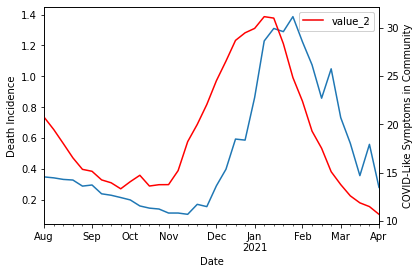

In [222]:
plot3 = data3.plot('Date','value_3',ylabel="Death Incidence")
plot3b = plot3.twinx()
data3.plot("Date",'value_2',ax=plot3b, color="red",ylabel="COVID-Like Symptoms in Community")

Both facebook indicators seems to be good lead indicators, since their trends are close copies to the death incidence, and that the trends in death incidence follows these indicators. However, comparing the two indicators, the first indicator looks more variable like because there are more fluctuations throughout, while th second indicator is relatively smooth.

**Exercise 4.** Using read_sql_query, for each variable compute the average of all states grouped by date.  Read it into a pandas dataframe.  The averaging should be done in SQL and then the pd.DataFrame should be constructed, the average should not happen after you read in the full data. In the end you should have one row for each date.  The rest of this is identical to the previous exercise...

For the two FB indicator variables, produce a plot comparing that to the death indicences. Plot the FB indicator variables as a time series in a secondary y axis and the death indicence as the primary y axis. You can just use pd.DataFrame.plot(). You should have the actual date on the X axis and not just an index number.

In [200]:
data4 = pd.DataFrame((pd.read_sql("select Date,avg(value_1),avg(value_2),avg(value_3) from state group by Date",engine)))
data4['Date']=pd.to_datetime(data4['Date'],format='%Y%m%d')
data4

,Date,avg(value_1),avg(value_2),avg(value_3)
0,2020-08-02,0.562981,21.953618,0.247421
1,2020-08-09,0.542575,21.417332,0.236180
2,2020-08-16,0.531083,20.494328,0.231787
3,2020-08-23,0.585938,19.913992,0.230129
4,2020-08-30,0.589086,19.860055,0.226178
5,2020-09-06,0.597153,19.493519,0.212067
6,2020-09-13,0.567799,18.749732,0.184445
7,2020-09-20,0.606910,19.568179,0.216156
8,2020-09-27,0.644012,20.473064,0.209089
9,2020-10-04,0.678232,21.725504,0.210709


<AxesSubplot:xlabel='Date', ylabel='Average COVID-Like Symptoms'>

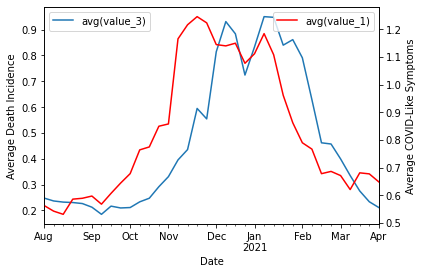

In [227]:
plot4 = data4.plot('Date','avg(value_3)',ylabel='Average Death Incidence')
plot4b = plot4.twinx()
data4.plot("Date",'avg(value_1)',ax=plot4b, color="red",ylabel="Average COVID-Like Symptoms")

<AxesSubplot:xlabel='Date', ylabel='Average COVID-Like Symptoms in Community'>

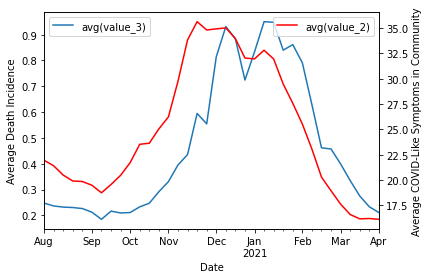

In [228]:
plot4 = data4.plot('Date','avg(value_3)',ylabel='Average Death Incidence')
plot4b = plot4.twinx()
data4.plot("Date",'avg(value_2)',ax=plot4b, color="red",ylabel="Average COVID-Like Symptoms in Community")

**Exercise 5** The Pearson correlation between variables a and b can be computed from 5 quantities...
```
n = count of rows
cross = sum(a * b)
sqr_1 = sum(a * a)
sqr_2 = sum(b * b)
mu_1 = avg(a)
mu_2 = avg(b)
```
using the following equation
```
(cross - n*mu_1*mu_2) / ((sqr_1 - n*mu_1**2)**0.5 * (sqr_2 - n*mu_2**2)**0.5)
```
Using only SQL commands, compute these quantities for variables smoothed_hh_cmnty_cli and smoothed_cli and grouped by date, reading this into a DataFrame.  Compute the Pearson correlation for each date using these quantities, and plot the time series of pearson correlation. 

In [319]:
from sqlalchemy.sql import func
n = (pd.read_sql("select Date,count(*) AS n from state group by Date",engine))
cross = (pd.read_sql("select sum(value_1*value_2) AS cross from state group by Date",engine))
sqr_1 = (pd.read_sql("select sum(value_1*value_1) AS sqr_1 from state group by Date",engine))
sqr_2 = (pd.read_sql("select sum(value_2*value_2) AS sqr_2 from state group by Date",engine))
mu_1 = (pd.read_sql("select avg(value_1) AS mu_1 from state group by Date",engine))
mu_2 = (pd.read_sql("select avg(value_2) AS mu_2 from state group by Date",engine))


data5 = n.join([cross,sqr_1,sqr_2,mu_1,mu_2])
data5.head()

,Date,n,cross,sqr_1,sqr_2,mu_1,mu_2
0,20200802,52,728.738019,20.198575,27406.761105,0.562981,21.953618
1,20200809,52,680.666318,18.566663,26375.227656,0.542575,21.417332
2,20200816,51,621.989518,16.839664,23698.226133,0.531083,20.494328
3,20200823,51,666.420844,21.020592,22318.089812,0.585938,19.913992
4,20200830,51,667.706250,21.445257,22230.500342,0.589086,19.860055


<AxesSubplot:xlabel='Date', ylabel='Pearson Correlation Between Indicators'>

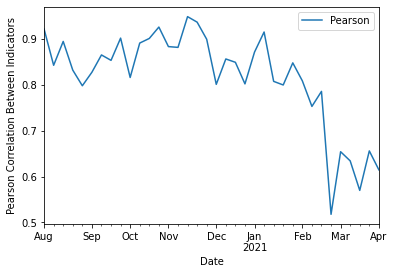

In [320]:
data5['Date']=pd.to_datetime(data5['Date'],format='%Y%m%d')
data5['Pearson']=(data5['cross'] - data5['n']*data5['mu_1']*data5['mu_2']) / ((data5['sqr_1'] - data5['n']*data5['mu_1']**2)**0.5 * (data5['sqr_2'] - data5['n']*data5['mu_2']**2)**0.5)
data5.plot('Date','Pearson',ylabel="Pearson Correlation Between Indicators")

## Acknowledgements
Discussed with Jose Lopez  
https://www.programiz.com/python-programming/datetime/strftime  
https://stackoverflow.com/questions/38067704/how-to-change-the-datetime-format-in-pandas  
https://stackoverflow.com/questions/33678435/pandas-plotting-with-twinx